<a href="https://colab.research.google.com/github/Shuraimi/PythonDataScienceHandbook/blob/master/Pivot_tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pivot tables

The *pivot tables* is a similar operation commonly seen in spreadsheets and programs that deal with tabular data.

The pivot table takes column wise data as input and groups data into a two dimensional table that provides a multi dimensional summarisation of the data.

**Difference between pivot and groupby**
This difference is confusing and it is helpful to think of pivot tables as *multidimensional* version of the GroupBy operation.

## Motivating pivot tables

We'll load the Titanic dataset from seaborn library.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
titanic=sns.load_dataset('titanic')

In [ ]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Pivot tables by hand

Yo check the number of survivors by gender.

In [ ]:
titanic.groupby('sex')['survived'].sum()

sex
female    233
male      109
Name: survived, dtype: int64

To perform this groupby one step deeper.
To check the survival status by both class and sex and aggregate with mean and unstack to get Multidimensional array.

In [ ]:
sur=titanic.groupby(['sex','class'])['survived']

In [ ]:
sur

In [ ]:
sur.mean().unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [ ]:
sur.aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


So what's the difference between `sur.aggregate('mean')` and `sur.mean()`

This one line code is not easy to read and understand therefore pandas has another routine pivot tables to get this type of multi dimensional representation.

## Pivot table syntax

Here's the pivot table syntax to perform the preceding operation.

In [ ]:
titanic.pivot_table('survived',index='sex',columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives a more readable approach than groupby.

### Multilevel pivot tables

Just like the grouping in groupby, we can add multiple levels in pivot tables using the `pd.cut()` and other options in it.

We'll bin the age using`pd.cut()`.

In [ ]:
age=pd.cut(titanic.age,[0,18,80])
titanic.pivot_table('survived',['sex',age],'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can also use this on columns. We'll use the `pd.qcut()` to automatically compute quantiles on fare.

In [ ]:
fare=pd.qcut(titanic.fare,2)
titanic.pivot_table('survived',index=['sex',age],columns=[fare,'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

The result is a four dimensional aggregation with hierarchical Indices shown in a grid demonstrating relationship between values.

### Additional pivot table options

The full signature to pivot_table is

In [ ]:
titanic.pivot_table?

Check the signature post of the documentation.

Here we'll discuss about the other options in the function. fill_value and dropna are used to deal with missing values and are straightforward.

The *aggfunc* keyword specifies the type of aggregation to be performed. It's set to mean by default and can have any of the aggregation type used in Groupby like the string representations ('mean','median','mode','count','min', etc) or a function that implements aggregation (np.mean(),min(), max())

It can also have a dictionary mapping column to the desired aggregations discussed before.

In [ ]:
titanic.pivot_table(index='sex',columns='class',aggfunc={'survived':sum,'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Here we've skipped the values keyword because when we define the aggfunc dictionary mapping, the values are automatically given.

We can also compute the total of all groups using the margins keyword.

In [ ]:
titanic.pivot_table('survived',index='sex',columns='class',margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


This automatically gives us info about the class-agnostics survival rate by gender, gender-agnostic survival rate by class and overall survival rate.

## Example : Birthrate data

In [ ]:
birth_df=pd.read_csv('/content/drive/MyDrive/Data Science /births.csv')

In [ ]:
birth_df.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


We'll start to understand the data a bit more using pivot tables.

We'll first create a decade column and look at male and female births as a function of decades.

In [ ]:

#removing the last digit from year and multiply by 10
birth_df['decade']=(birth_df.year//10)*10

In [ ]:
#look at male and female births as a function of decade
birth_df.pivot_table('births',index='decade',columns='gender',aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


We see that births of male are more than females. We can see this by a plot.

Text(0, 0.5, 'Total births per year')

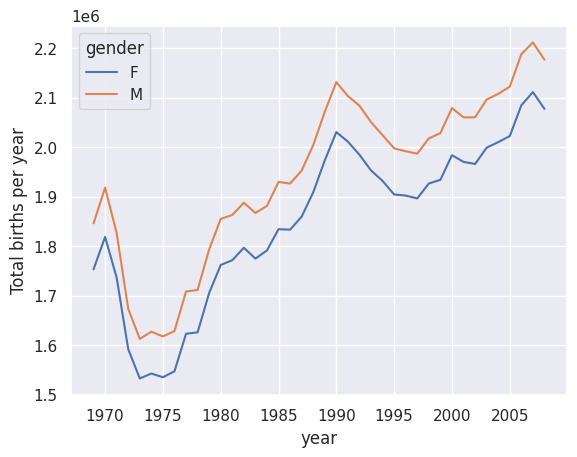

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
birth_df.pivot_table('births',index='year', columns='gender',aggfunc='sum').plot()
plt.ylabel('Total births per year')

By using the simple pivot table and plot(), we can see the annual trend in birth data.

### Further data exploration

We'll remove the outliers in this data set using sigma-clipping operations.

In [ ]:
quartiles=np.percentile(birth_df.births,[25,50,75])
mu=quartiles[1]
sig=0.74*(quartiles[2]-quartiles[0])

The next line is a robust estimate of the sample mean and 0.74 comes from IQR of the Gaussian distribution.

With this we can use the query() to get the rows which are outside this range.

This will be discussed further.

In [ ]:
birth_df = birth_df.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

In [ ]:
birth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14610 entries, 0 to 15066
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    14610 non-null  int64 
 1   month   14610 non-null  int64 
 2   day     14610 non-null  int64 
 3   gender  14610 non-null  object
 4   births  14610 non-null  int64 
 5   decade  14610 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 799.0+ KB


Previously day was of object type and now set it as int type.

In [ ]:
birth_df['day']=birth_df['day'].astype(int)

<ipython-input-37-e5a6224f11a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  birth_df['day']=birth_df['day'].astype(int)


Finally we can create a DateTime index using day,month and year

In [ ]:
birth_df.index = pd.to_datetime(10000 * birth_df.year +
 100 * birth_df.month +
birth_df.day, format='%Y%m%d')
birth_df['dayofweek'] = birth_df.index.dayofweek

<ipython-input-42-84492e512654>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  birth_df['dayofweek'] = birth_df.index.dayofweek


To check births of days of the week for several decades.

<ipython-input-48-ae22b021d7c7>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])


Text(0, 0.5, 'means births by days')

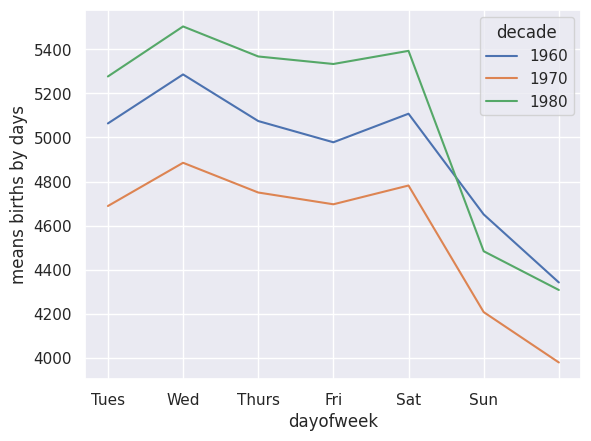

In [ ]:

import matplotlib as mlt
birth_df.pivot_table('births',index='dayofweek',columns='decade').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('means births by days')

The 1990s and 2000s data is missing and weekends birth are less than weekdays.

Another interesting plot is to plot the mean number of births by day of the year.

In [ ]:
births_by_date=birth_df.pivot_table('births',[birth_df.index.month,birth_df.index.day])

In [ ]:
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

This is a mutli index over months and days. To make this easily plottable we turn these months and days into date using a dummy year variable.

In [ ]:
births_by_date.index=[pd.datetime(2012,month,day) for (month,day) in births_by_date.index]

<ipython-input-52-1dde994f9d9f>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_by_date.index=[pd.datetime(2012,month,day) for (month,day) in births_by_date.index]


In [ ]:
births_by_date

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625
...,...
2012-12-27,4850.150
2012-12-28,5044.200
2012-12-29,5120.150
2012-12-30,5172.350


Focusing on the month and say only, we now have a time series data reflecting average number of births by date of the year.

<Axes: >

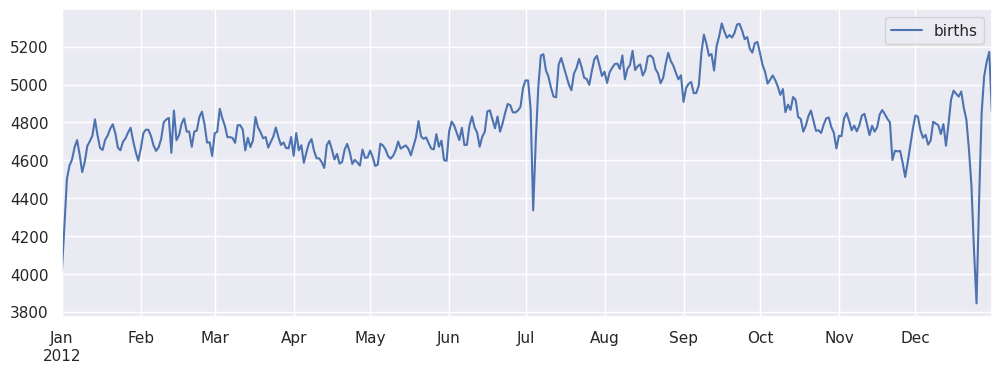

In [ ]:
fig,ax=plt.subplots(figsize=(12,4))
births_by_date.plot(ax=ax)